In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import zipfile
import os
zip_file_path = '/content/drive/MyDrive/x_train.zip'
extract_dir = '/content/'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

zip_file_path = '/content/drive/MyDrive/x_test.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [3]:
import h5py
y_train_h5_path = '/content/drive/My Drive/y_train.h5'
y_test_h5_path = '/content/drive/My Drive/y_test.h5'

# Open the HDF5 file for reading
with h5py.File(y_train_h5_path, 'r') as hf:
    # Read the dataset
    y_train = hf['y_train'][:]
    # Convert the dataset to a list of strings
    y_train_list = [str(item, 'utf-8') for item in y_train]

# Open the HDF5 file for reading
with h5py.File(y_test_h5_path, 'r') as hf:
    # Read the dataset
    y_test = hf['y_test'][:]
    # Convert the dataset to a list of strings
    y_test_list = [str(item, 'utf-8') for item in y_test]

# Open the HDF5 file for reading
with h5py.File('x_train.h5', 'r') as hf:
    # Read the dataset
    x_train = hf['x_train'][:]

# Open the HDF5 file for reading
with h5py.File('x_test.h5', 'r') as hf:
    # Read the dataset
    x_test = hf['x_test'][:]

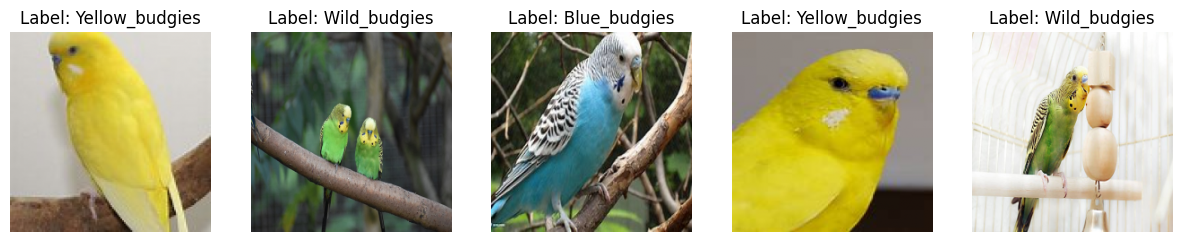

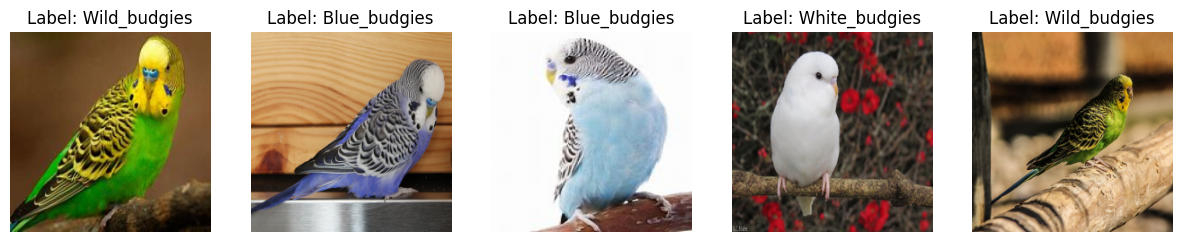

In [4]:
import matplotlib.pyplot as plt

def visualize_images(images, labels):
    num_images = len(images)
    if num_images == 0:
        print("No images found in the HDF5 file.")
        return
    plt.figure(figsize=(15, 5))
    for i, image in enumerate(images[:5]):  # Visualize only the first 5 images
        plt.subplot(1, 5, i+1)
        plt.imshow(image)
        plt.axis('off')
        plt.title("Label: {}".format(labels[i]))
    plt.show()

visualize_images(x_test, y_test_list)
visualize_images(x_train, y_train_list)

In [5]:
!pip install transformers
!pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [6]:
from PIL import Image
import numpy as np
from torchvision import transforms

# preprocessing with some extra transforms
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ])

def preprocess_image(image):
    # Convert image to PIL Image if it's not already
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image)
    # Apply preprocessing transforms
    image = preprocess(image).unsqueeze(0)
    return image


In [7]:
# Importing the libraries needed
from PIL import Image
from transformers import EfficientNetImageProcessor, EfficientNetForImageClassification

# Loading the model and preprocessor from HuggingFace
preprocessor = EfficientNetImageProcessor.from_pretrained("dennisjooo/Birds-Classifier-EfficientNetB2")
model = EfficientNetForImageClassification.from_pretrained("dennisjooo/Birds-Classifier-EfficientNetB2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/495 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/31.2k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/34.1M [00:00<?, ?B/s]

In [9]:
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import numpy as np
import torch

y_train_strings = [str(label) for label in y_train]
y_train_strings = np.array(y_train_strings).reshape(-1, 1)

# Create a OneHotEncoder object
encoder = OneHotEncoder()

# Fit the encoder on the list of strings
encoder.fit(y_train_strings)

# Transform the list of strings using the encoder
y_train_encoded = encoder.transform(y_train_strings)

# Convert the encoded data to a PyTorch tensor
y_train_tensor = torch.Tensor(y_train_encoded.toarray())

x_train_tensor = torch.Tensor(x_train)
# x_train_tensor = torch.transpose(x_train_tensor, 1,3)
x_train_tensor = x_train_tensor.permute(0, 3, 1, 2)
# Convert one-hot encoded labels to class indices
y_train_indices = torch.argmax(y_train_tensor, dim=1)

# Create a TensorDataset with class indices as labels
dataset = TensorDataset(x_train_tensor, y_train_indices)

# Create a DataLoader
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [10]:
y_test_strings = [str(label) for label in y_test]
y_test_strings = np.array(y_test_strings).reshape(-1, 1)

# Create a OneHotEncoder object
encoder = OneHotEncoder()

# Fit the encoder on the list of strings
encoder.fit(y_test_strings)

# Transform the list of strings using the encoder
y_test_encoded = encoder.transform(y_test_strings)

# Convert the encoded data to a PyTorch tensor
y_test_tensor = torch.Tensor(y_test_encoded.toarray())

x_test_tensor = torch.Tensor(x_test)
# x_test_tesnor = torch.transpose(x_test_tensor, 1,3)
x_test_tensor = x_test_tensor.permute(0, 3, 1, 2)
# Convert one-hot encoded labels to class indices
y_test_indices = torch.argmax(y_test_tensor, dim=1)

# Create a TensorDataset with class indices as labels
dataset = TensorDataset(x_test_tensor, y_test_indices)

# Create a DataLoader
test_dataloader = DataLoader(dataset, batch_size=20, shuffle=True)


In [11]:
# Iterate over the first batch in the DataLoader
for batch in train_dataloader:
    # Unpack the batch into inputs and labels
    inputs, labels = batch

    # Print the shape of the inputs and labels
    print("Input shape:", inputs.shape)
    print("Label shape:", labels.shape)

    # Optionally, print the first few elements of the inputs and labels
    print("First few elements of inputs:", inputs[:5])
    print("First few elements of labels:", labels[:5])

    # Break the loop after inspecting the first batch
    break

Input shape: torch.Size([64, 3, 224, 224])
Label shape: torch.Size([64])
First few elements of inputs: tensor([[[[0.1478, 0.1314, 0.1267,  ..., 0.0196, 0.0196, 0.0196],
          [0.0991, 0.1346, 0.1576,  ..., 0.0196, 0.0196, 0.0196],
          [0.1144, 0.1719, 0.1815,  ..., 0.0196, 0.0196, 0.0196],
          ...,
          [0.2078, 0.2078, 0.2078,  ..., 0.1647, 0.1647, 0.1647],
          [0.2078, 0.2078, 0.2078,  ..., 0.1647, 0.1647, 0.1647],
          [0.2078, 0.2078, 0.2078,  ..., 0.1647, 0.1647, 0.1647]],

         [[0.1186, 0.1038, 0.0992,  ..., 0.0392, 0.0392, 0.0392],
          [0.0674, 0.1064, 0.1325,  ..., 0.0392, 0.0392, 0.0392],
          [0.0843, 0.1445, 0.1549,  ..., 0.0392, 0.0392, 0.0392],
          ...,
          [0.2078, 0.2078, 0.2020,  ..., 0.1569, 0.1569, 0.1569],
          [0.2078, 0.2077, 0.2001,  ..., 0.1569, 0.1569, 0.1569],
          [0.2078, 0.2058, 0.2000,  ..., 0.1569, 0.1569, 0.1569]],

         [[0.1066, 0.0824, 0.0740,  ..., 0.0235, 0.0235, 0.0235],
     

In [12]:
# create labels
labels = torch.flatten(labels)
print(labels)

tensor([3, 0, 1, 3, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 4, 0, 1, 4, 0, 2,
        0, 0, 2, 0, 0, 3, 0, 0, 2, 3, 4, 3, 3, 1, 0, 4, 3, 3, 1, 3, 2, 1, 1, 0,
        2, 4, 2, 0, 0, 4, 4, 0, 1, 0, 3, 2, 4, 3, 0, 3])


In [13]:
import torch.optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from keras.callbacks import ReduceLROnPlateau

# Define your optimizer and any other necessary components
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)  # Learning rate scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define your training loop with gradient accumulation
def train_epoch(model, dataloader, optimizer, device, accumulation_steps):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    accumulated_loss = 0.0

    for i, (images, labels) in enumerate(tqdm(dataloader, desc="Training")):
        images, labels = images.to(device), labels.to(device)
        labels = torch.flatten(labels).long()
        labels = labels.view(-1)

        optimizer.zero_grad()
        outputs = model(images)

        if hasattr(outputs, 'logits'):
              outputs = outputs.logits

        loss = F.cross_entropy(outputs, labels)
        loss.backward()

        # Accumulate gradients
        accumulated_loss += loss.item()

        if (i + 1) % accumulation_steps == 0:
            # Update parameters every accumulation_steps batches
            optimizer.step()
            optimizer.zero_grad()
            total_loss += accumulated_loss
            accumulated_loss = 0.0

            # Detach intermediate tensors to release memory
            images.detach()
            labels.detach()
            outputs.detach()
            torch.cuda.empty_cache()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Update parameters for any remaining accumulated gradients
    if accumulated_loss > 0:
        optimizer.step()
        total_loss += accumulated_loss

    # Detach remaining tensors to release memory
    images.detach()
    labels.detach()
    outputs.detach()
    torch.cuda.empty_cache()

    accuracy = correct / total
    avg_loss = total_loss / len(dataloader)

    return avg_loss, accuracy

# Define your validation loop
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if hasattr(outputs, 'logits'):
              outputs = outputs.logits

            loss = F.cross_entropy(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    avg_loss = total_loss / len(dataloader)

    return avg_loss, accuracy

num_epochs = 1
accumulation_steps = 4

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_epoch(model, train_dataloader, optimizer, device, accumulation_steps)
    val_loss, val_accuracy = evaluate(model, test_dataloader, device)

    print(f"\nEpoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}\n")


Validation: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch 1/1, Train Loss: 17.8130, Train Accuracy: 0.0021, Val Loss: 17.0420, Val Accuracy: 0.0000

